# Progressively Approximating a DOI function 
The idea here is that in some cases, computing a doi function simply takes too long. 
Instead, we therefore train a regression model on a subset of the data and then progressively retrain it on a progressively maintained sample of the data (see ```progressive_sampling.ipynb```)

bernoulli nb: 0.37727928161621094s


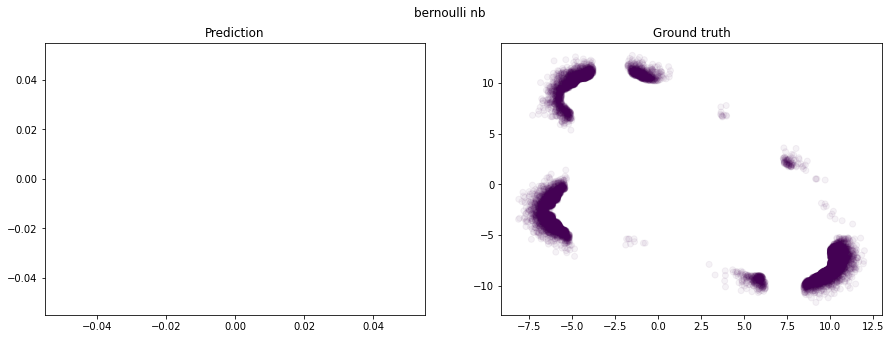

passive-aggressive: 0.428910493850708s


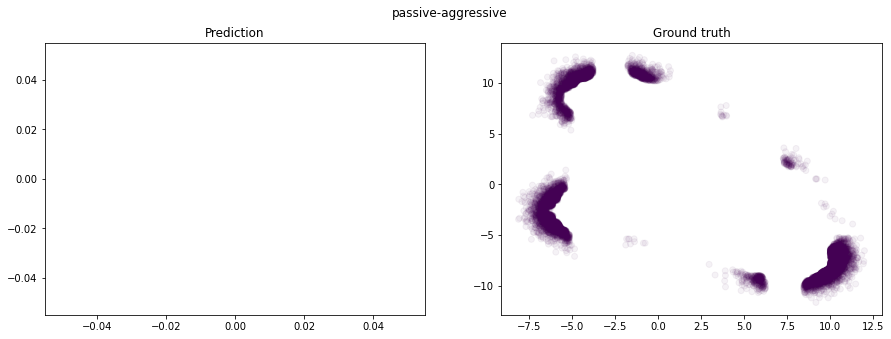

decision tree: 0.3650217056274414s


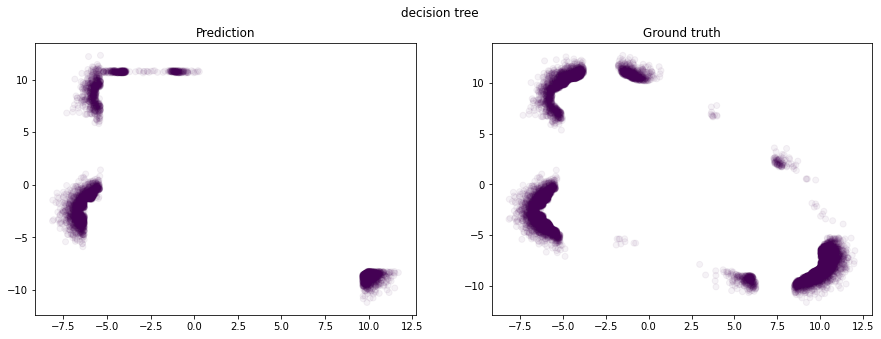

random forest: 0.8756804466247559s


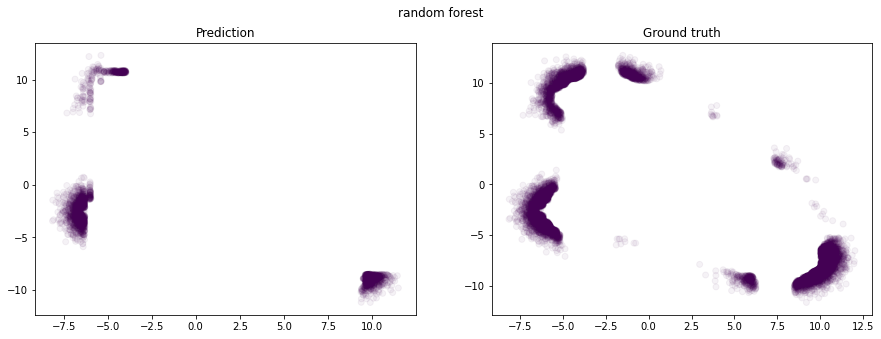

gradient boosting: 0.5077052116394043s


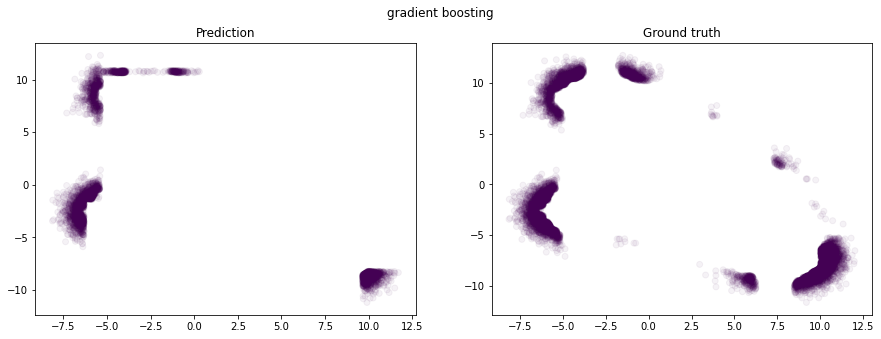

C:\Users\au629923\AppData\Local\Temp/ipykernel_19248/1558785952.py:120: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  columns = np.array(models)[:, 0]


(0.0, 1.0)

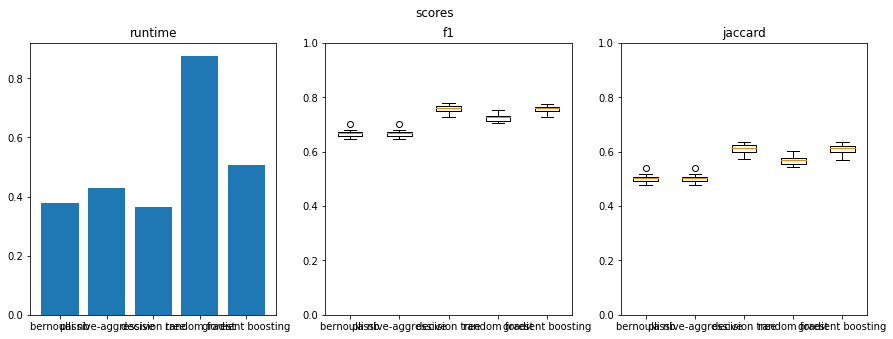

In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, jaccard_score, f1_score
from sklearn.datasets import make_blobs
from imblearn.under_sampling import RandomUnderSampler

# outlier models used for doi computation
# from sklearn.svm import OneClassSVM
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest


# approximation models used for testing
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


# use outlierness computation as doi function for now
contamination = 0.01
# doi = EllipticEnvelope(contamination=contamination, random_state=0)
# doi = OneClassSVM(nu=contamination, kernel="rbf", gamma=0.1)
# doi = LocalOutlierFactor(n_neighbors=35, contamination=contamination)
doi = IsolationForest(contamination=contamination, random_state=0)

# generate data
N = 1000000
training_size = 1000
features = 2
chunk_size = 1000

blobs_params = dict(n_samples=N, n_features=features)
X = make_blobs(centers=6, cluster_std=1, **blobs_params)[0]

# compute the "ground truth" by evaluating the doi function over the entire dataset (only useful in 
# benchmarking, since not feasible in PVA!)
y = doi.fit_predict(X)

# since the doi classes (for outlierness) are highly imbalanced (contamination variable indicates 
# the percentage that is considered outlier), we balance the classes before evaluation.
rus = RandomUnderSampler(random_state=0)
X_res, y_res = rus.fit_resample(X, y)
idx = np.random.permutation(len(X_res))
X_res, y_res = X_res[idx], y_res[idx]

steps = (len(X_res) // chunk_size) + 1

models = [
  ["bernoulli nb", BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None, fit_prior=True)],
  ["passive-aggressive", PassiveAggressiveClassifier(max_iter=1000, random_state=0, tol=1e-3)],
  ["decision tree", DecisionTreeClassifier(random_state=0)],
  ["random forest", RandomForestClassifier(random_state=0)],
  ["gradient boosting", GradientBoostingClassifier(random_state=0)],
]

# containers for benchmarking variables
TIMES = []
F_SCORE = []
J_SCORE = []

for title, model in models:
  prediction = np.array([])

  # scores
  precision = np.array([])
  f1 = np.array([])
  jaccard = np.array([])

  start = time.time()
  for i in range(steps):
    X_ = X_res[i * chunk_size: (i+1) * chunk_size]
    y_ = y_res[i * chunk_size: (i+1) * chunk_size]

    # on the first chunk, train the doi predictor by evaluating the doi function over the current
    # chunk of data
    if i == 0:
      X_train = X[:training_size]
      y_approx = doi.fit_predict(X_train)
      model.fit(X_train, y_approx)

    y_pred = model.predict(X_)
    prediction = np.append(prediction, y_pred)

    # score the prediction against the ground truth
    p = precision_score(y_, y_pred)
    f = f1_score(y_, y_pred)
    j = jaccard_score(y_, y_pred)

    # save the scores
    precision = np.append(precision, p)
    f1 = np.append(f1, f)
    jaccard = np.append(jaccard, j)

  end = time.time()
  print(f"{title}: {end-start}s")

  TIMES = TIMES + [end-start]
  F_SCORE = F_SCORE + [f1]
  J_SCORE = J_SCORE + [jaccard]

  # create side-by-side visualization of prediction and ground_truth
  fig, (ax1) = plt.subplots(1, 2, figsize=(15, 5))
  fig.suptitle(title)

  alpha = 0.05
  ax1[0].set_title("Prediction")
  ax1[0].scatter(x=X_res[prediction == -1,0], y=X_res[prediction == -1,1], c=prediction[prediction == -1], alpha=alpha)
  ax1[1].set_title("Ground truth")
  ax1[1].scatter(x=X_res[y_res == -1,0], y=X_res[y_res == -1,1], c=y_res[y_res == -1], alpha=alpha)
  plt.show()

TIMES = np.array(TIMES)
F_SCORE = np.array(F_SCORE)
J_SCORE = np.array(J_SCORE)

# visualize the benchmarks
columns = np.array(models)[:, 0]
fig, (ax) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("scores")
ax[0].set_title("runtime")
ax[0].bar(columns, TIMES)
ax[1].set_title("f1")
ax[1].boxplot(F_SCORE.transpose(), labels=columns)
ax[1].set_ylim([0, 1])
ax[2].set_title("jaccard")
ax[2].boxplot(J_SCORE.transpose(), labels=columns)
ax[2].set_ylim([0, 1])